# Latam Challenge

## Problema
El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL. Para cada vuelo se cuenta con la siguiente información:
- Fecha-I : Fecha y hora programada del vuelo.
- Vlo-I : Número de vuelo programado.
- Ori-I : Código de ciudad de origen programado.
- Des-I : Código de ciudad de destino programado.
- Emp-I : Código aerolínea de vuelo programado.
- Fecha-O : Fecha y hora de operación del vuelo.
- Vlo-O : Número de vuelo de operación del vuelo.
- Ori-O : Código de ciudad de origen de operación
- Des-O : Código de ciudad de destino de operación.
- Emp-O : Código aerolínea de vuelo operado.
- DIA : Día del mes de operación del vuelo.
- MES : Número de mes de operación del vuelo.
- AÑO : Año de operación del vuelo.
- DIANOM : Día de la semana de operación del vuelo.
- TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional.
- OPERA : Nombre de aerolínea que opera.
- SIGLAORI : Nombre ciudad origen.
- SIGLADES : Nombre ciudad destino

## Desafío
1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?
2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :
    - temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
    - dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
    - atraso_15 : 1 si dif_min > 15, 0 si no.
    - periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .
3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?
4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.
Siéntete libre de generar variables adicionales y/o complementar con variables externas.
5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?

## Solución

In [1]:
# libraries
sys.path.append(r'..\common')
import sys
import pandas as pd
import numpy as np
import datetime as dt
from IPython.core.interactiveshell import InteractiveShell
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from datetime import date, datetime
from category_encoders import *
from dython.nominal import associations
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
import pickle
import shap
import common_helper as ch
import warnings
warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.2f}'.format

c:\Users\Nia\Desktop\latam-test\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 0. Lectura datos

In [2]:
%%time
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
schema = {
          'Fecha-I': object,
          'Vlo-I': str, 
          'Emp-I': str,
          'Des-I': str, 
          'Ori-I': str, #fijo
          'Fecha-O': object,
          'Vlo-O': str,
          'Ori-O': str, #fijo
          'Des-O': str, 
          'Emp-O':str, 
          'DIA': np.int64, 
          'MES': np.int64, 
          'AÑO': np.int64, 
          'DIANOM': str, 
          'TIPOVUELO': str,
          'OPERA': str, 
          'SIGLAORI': str, 
          'SIGLADES': str
          }
df = pd.read_csv(r'..\..\data\dataset_SCL.csv', dtype=schema, parse_dates=['Fecha-I', 'Fecha-O'], date_parser=dateparse)
df.columns = [name.lower().replace('-', '_').replace('ñ', 'ni') for name in df.columns]
df.head()

CPU times: total: 1.36 s
Wall time: 1.47 s


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,anio,dianom,tipovuelo,opera,siglaori,siglades
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


### 1. Distribución de los datos.

In [3]:
%%time
# Describe
df.describe(include='all', datetime_is_numeric=True)

CPU times: total: 109 ms
Wall time: 112 ms


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,anio,dianom,tipovuelo,opera,siglaori,siglades
count,68206,68206,68206,68206,68206,68206,68205,68206,68206,68206,"68,206.00","68,206.00","68,206.00",68206,68206,68206,68206,68206
unique,NaN,584,1,64,30,NaN,861,1,63,32,NaN,NaN,NaN,7,2,23,1,62
top,NaN,174,SCEL,SCFA,LAN,NaN,174,SCEL,SCFA,LAN,NaN,NaN,NaN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires
freq,NaN,686,68206,5787,37611,NaN,649,68206,5786,20988,NaN,NaN,NaN,10292,36966,40892,68206,6335
mean,2017-07-05 12:11:25.320059648,NaN,NaN,NaN,NaN,2017-07-05 12:20:31.971380992,NaN,NaN,NaN,NaN,15.71,6.62,"2,017.00",NaN,NaN,NaN,NaN,NaN
min,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,2017-01-01 00:04:00,NaN,NaN,NaN,NaN,1.00,1.00,"2,017.00",NaN,NaN,NaN,NaN,NaN
25%,2017-03-31 12:41:15,NaN,NaN,NaN,NaN,2017-03-31 12:51:15,NaN,NaN,NaN,NaN,8.00,3.00,"2,017.00",NaN,NaN,NaN,NaN,NaN
50%,2017-07-10 05:30:00,NaN,NaN,NaN,NaN,2017-07-10 05:37:00,NaN,NaN,NaN,NaN,16.00,7.00,"2,017.00",NaN,NaN,NaN,NaN,NaN
75%,2017-10-08 11:18:45,NaN,NaN,NaN,NaN,2017-10-08 11:19:45,NaN,NaN,NaN,NaN,23.00,10.00,"2,017.00",NaN,NaN,NaN,NaN,NaN
max,2017-12-31 23:55:00,NaN,NaN,NaN,NaN,2018-01-01 00:12:00,NaN,NaN,NaN,NaN,31.00,12.00,"2,018.00",NaN,NaN,NaN,NaN,NaN


In [4]:
%%time
# pandas profiling
# Discard columns=['vlo_i', 'ori_i', 'ori_o', 'siglaori', 'anio'] because they are not useful
profile = ProfileReport(df.drop(columns=['vlo_i', 'ori_i', 'ori_o', 'siglaori', 'anio']), title="Profiling Report")

CPU times: total: 15.6 ms
Wall time: 11.1 ms


In [5]:
# Report Interactive in a cell
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
%%time
profile.to_file(r'..\..\docs\Descriptive_report.html')

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 531 ms
Wall time: 552 ms


**Conclusiones**:

- Dado que los campos de fecha los datos ``ori_i``  ``ori_o`` y ``siglaori`` y `anio` solo tienen valores constantes se excluyen del profiling. 
- El campo ``vlo_i`` tambièn se excluye dado que es un identificador que no aporta información.
- Sobre los dos campos de fecha ``fecha_i`` y ``fecha_o`` se observan picos sobre ciertas temporadas (Tambièn se observa con la variable ``mes``)
    * De enero, hasta comienzos de marzo.
    * A mediados de Julio hay un pequeño pico, donde a partir de agosto el número de vuelos aumenta hasta diciembre.
- El campo ```día``` se observa con una baja sobre los ultimos días(Asociado posiblemente a que algunos meses no tienen los 31 días)
- Alta cardinalidad sobre algunas de las variables categoricas, asi como altas correlaciones entre las mismas.


### 2. Generación de Columnas Adicionales.

Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :
- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
- dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
- atraso_15 : 1 si dif_min > 15, 0 si no.
- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
Fecha-I .

In [7]:
%%time
# Copy dataframe
syntetic_df = df.copy()

# New columns
# Temporada alta
syntetic_df['temporada_alta'] = np.where(((syntetic_df['fecha_i'].dt.date >= dt.date(2017, 12, 15)) & 
                                         (syntetic_df['fecha_i'].dt.date  <=dt.date(2017, 12, 31))) |
                                         ((syntetic_df['fecha_i'].dt.date >= dt.date(2017, 1, 1)) & 
                                         (syntetic_df['fecha_i'].dt.date  <=dt.date(2017, 3, 3))) |
                                         ((syntetic_df['fecha_i'].dt.date  >= dt.date(2017, 7, 15)) & 
                                         (syntetic_df['fecha_i'].dt.date  <= dt.date(2017, 7, 31))) |
                                         ((syntetic_df['fecha_i'].dt.date  >= dt.date(2017, 9, 11)) & 
                                         (syntetic_df['fecha_i'].dt.date  <= dt.date(2017, 9, 30))), 1, 0)

# Diferecia de minutos 
syntetic_df['df_min'] = (syntetic_df['fecha_o'] - syntetic_df['fecha_i'] ).dt.total_seconds()/60

# Flag atraso 15+ minutos
syntetic_df['atraso_15'] = np.where(syntetic_df['df_min']>15, 1, 0)

# Periodo del día 
syntetic_df['periodo_dia'] = np.where((syntetic_df['fecha_i'].dt.time >= dt.time(5,0,0)) & (syntetic_df['fecha_i'].dt.time <= dt.time(11,59,59)), 'manana', 
                                      np.where((syntetic_df['fecha_i'].dt.time >= dt.time(12, 0, 0)) & (syntetic_df['fecha_i'].dt.time <= dt.time(18,59,59)), 'tarde', 'noche'))

syntetic_df.head(5)


CPU times: total: 234 ms
Wall time: 230 ms


,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,anio,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,df_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.00,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.00,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,1,9.00,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.00,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.00,0,noche


In [8]:
# Validate new columns
print('Temporada alta:')
syntetic_df.groupby(['temporada_alta', 
                     df['fecha_i'].dt.strftime('%m')+'-'+df['fecha_i'].dt.strftime('%B')]).agg({'fecha_i':['min', 'max'],
                         })

print('Atraso:')
syntetic_df.groupby('atraso_15').agg({'df_min':['min', 'max'],})

print('Periodo día:')
syntetic_df['hour'] = syntetic_df['fecha_i'].dt.time
syntetic_df.groupby(['periodo_dia', df['fecha_i'].dt.strftime('%H')]).agg({'hour':['min', 'max'],})
syntetic_df.drop(columns=['hour'], inplace=True)

Temporada alta:


fecha_i                    
                                            min                 max
temporada_alta fecha_i                                             
0              03-March     2017-03-04 00:35:00 2017-03-31 23:40:00
               04-April     2017-04-01 00:55:00 2017-04-30 23:50:00
               05-May       2017-05-01 00:55:00 2017-05-31 22:50:00
               06-June      2017-06-01 00:05:00 2017-06-30 23:55:00
               07-July      2017-07-01 00:05:00 2017-07-14 23:12:00
               08-August    2017-08-01 00:05:00 2017-08-31 23:50:00
               09-September 2017-09-01 00:30:00 2017-09-10 23:50:00
               10-October   2017-10-01 00:10:00 2017-10-31 23:40:00
               11-November  2017-11-01 00:15:00 2017-11-30 23:45:00
               12-December  2017-12-01 00:25:00 2017-12-14 23:45:00
1              01-January   2017-01-01 00:15:00 2017-01-31 23:55:00
               02-February  2017-02-01 00:05:00 2017-02-28 23:55:00
               03-March     2017-03-01 00:30:00 2017-03-03 23:55:00
               07-July      2017-07-15 00:05:00 2017-07-31 23:50:00
               09-September 2017-09-11 00:40:00 2017-09-30 23:50:00
               12-December  2017-12-15 00:25:00 2017-12-31 23:55:00

Atraso:


df_min       
             min    max
atraso_15              
0         -14.00  15.00
1          16.00 161.00

Periodo día:


hour          
                          min       max
periodo_dia fecha_i                    
manana      05       05:00:00  05:59:00
            06       06:00:00  06:56:00
            07       07:00:00  07:59:00
            08       08:00:00  08:59:00
            09       09:00:00  09:58:00
            10       10:00:00  10:59:00
            11       11:00:00  11:59:00
noche       00       00:00:00  00:55:00
            01       01:00:00  01:55:00
            02       02:00:00  02:55:00
            03       03:00:00  03:55:00
            04       04:00:00  04:55:00
            19       19:00:00  19:59:00
            20       20:00:00  20:59:00
            21       21:00:00  21:59:00
            22       22:00:00  22:59:00
            23       23:00:00  23:59:00
tarde       12       12:00:00  12:59:00
            13       13:00:00  13:59:00
            14       14:00:00  14:59:00
            15       15:00:00  15:59:00
            16       16:00:00  16:59:00
            17       17:00:00  17:59:00
            18       18:00:00  18:59:00

In [9]:
# Export to csv
syntetic_df.to_csv('../../data/synthetic_features.csv', index=False)

### 3. Composición del atraso.

¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?


#### Por Destino:

In [10]:
df_groupped = syntetic_df.groupby(['siglades'], as_index=False)[['atraso_15']].mean().sort_values(by='atraso_15', ascending=False)
df_groupped.reset_index(drop=True, inplace=True)

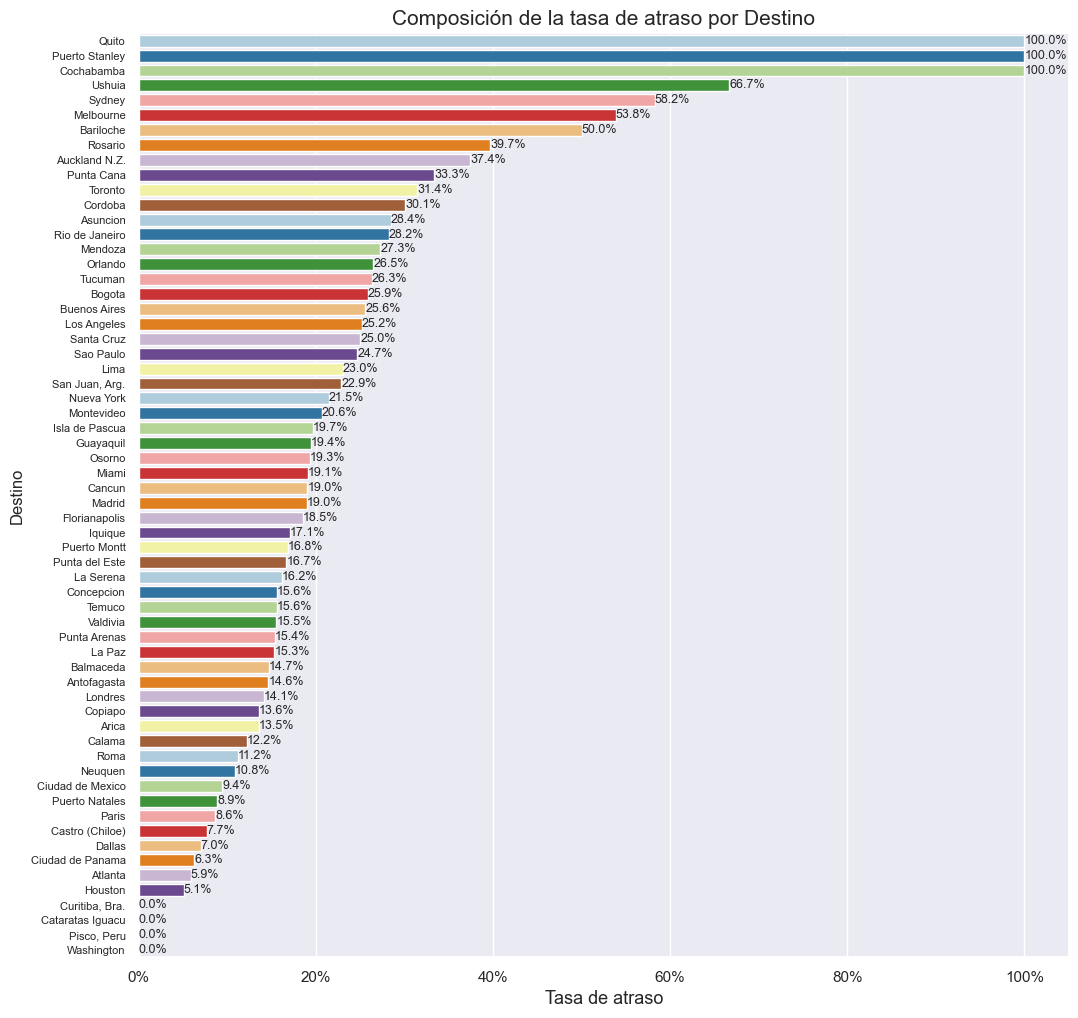

In [11]:
sns.set(rc = {'figure.figsize':(12,12)})
ax = sns.barplot(y=df_groupped['siglades'], x=df_groupped['atraso_15'], palette='Paired')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1));
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8);
labels = [f'{i*100:.1f}%' for i in df_groupped['atraso_15'].values]
ax.bar_label(ax.containers[0], labels=labels, fontsize=9);
ax.set_ylabel('Destino', fontsize=12);
ax.set_xlabel('Tasa de atraso', fontsize=13);
ax.set_title('Composición de la tasa de atraso por Destino', fontsize=15);

#### Por Aerolinea:

In [12]:
df_groupped = syntetic_df.groupby(['opera'], as_index=False)[['atraso_15']].mean().sort_values(by='atraso_15', ascending=False)
df_groupped.reset_index(drop=True, inplace=True)

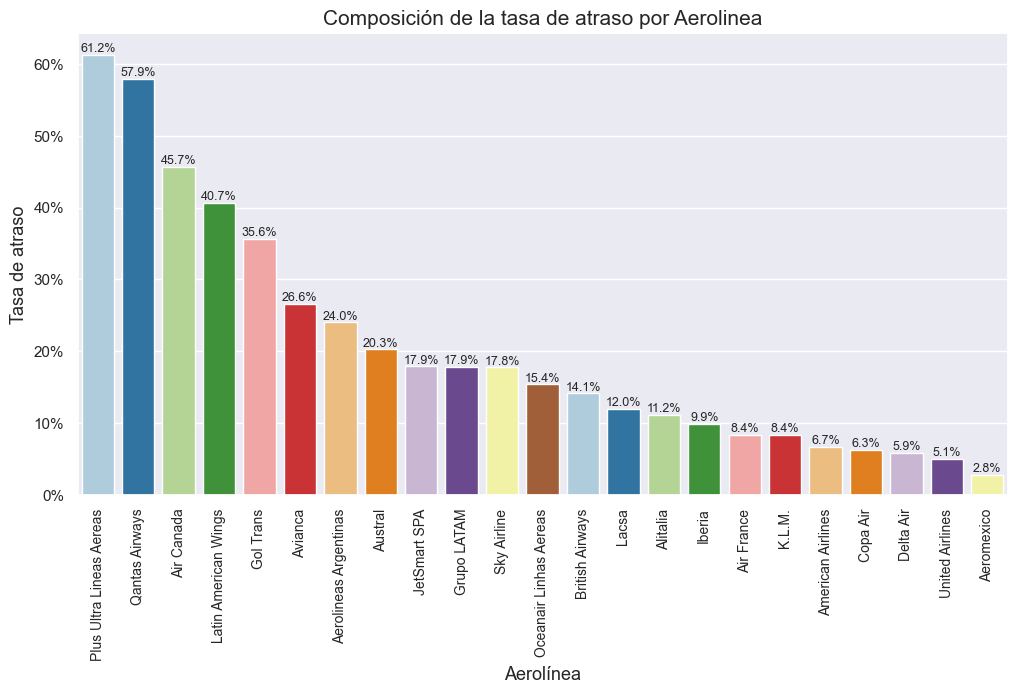

In [13]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.barplot(x=df_groupped['opera'], y=df_groupped['atraso_15'], palette='Paired')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1));
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10);
labels = [f'{i*100:.1f}%' for i in df_groupped['atraso_15'].values]
ax.bar_label(ax.containers[0], labels=labels, fontsize=9);
ax.set_xlabel('Aerolínea', fontsize=13);
ax.set_ylabel('Tasa de atraso', fontsize=13);
ax.set_title('Composición de la tasa de atraso por Aerolinea', fontsize=15);

#### Por Mes del año:

In [14]:
df_groupped = syntetic_df.groupby(['mes'], as_index=False)[['atraso_15']].mean().sort_values(by='atraso_15', ascending=False)
df_groupped.reset_index(drop=True, inplace=True)
df_groupped.sort_values(by='mes', ascending=True, inplace=True)

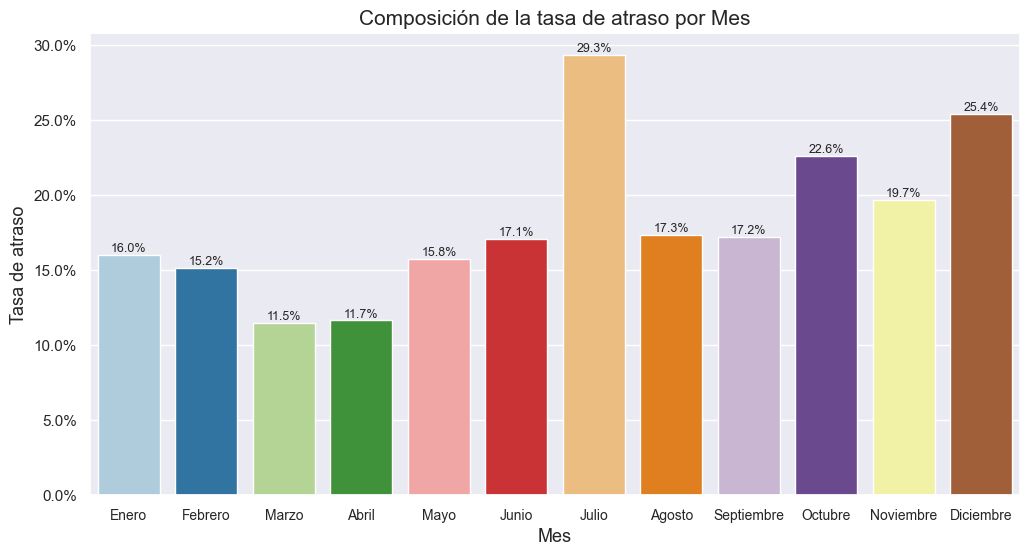

In [15]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.barplot(x=df_groupped['mes'], y=df_groupped['atraso_15'], palette='Paired')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1));
ax.set_xticklabels(
    labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'], 
    fontsize=10);
labels = [f'{i*100:.1f}%' for i in df_groupped['atraso_15'].values]
ax.bar_label(ax.containers[0], labels=labels, fontsize=9);
ax.set_xlabel('Mes', fontsize=13);
ax.set_ylabel('Tasa de atraso', fontsize=13);
ax.set_title('Composición de la tasa de atraso por Mes', fontsize=15);

#### Por día de la semana:

In [16]:
df_groupped = syntetic_df.groupby(['dianom'], as_index=False)[['atraso_15']].mean().sort_values(by='atraso_15', ascending=False)
df_groupped.reset_index(drop=True, inplace=True)
df_groupped['dianom'] = pd.Categorical(df_groupped['dianom'], ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'],  ordered=True)
df_groupped.sort_values(by='dianom', ascending=True, inplace=True)

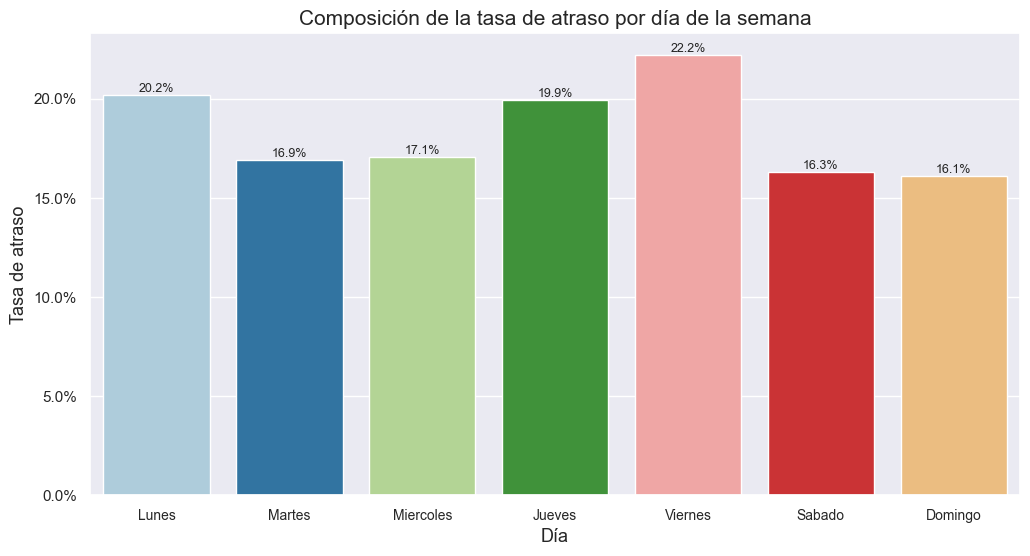

In [17]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.barplot(x=df_groupped['dianom'], y=df_groupped['atraso_15'], palette='Paired', 
                 order=['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1));
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10);
labels = [f'{i*100:.1f}%' for i in df_groupped['atraso_15'].values]
ax.bar_label(ax.containers[0], labels=labels, fontsize=9);
ax.set_xlabel('Día', fontsize=13);
ax.set_ylabel('Tasa de atraso', fontsize=13);
ax.set_title('Composición de la tasa de atraso por día de la semana', fontsize=15);

#### Por temporada:

In [18]:
df_groupped = syntetic_df.groupby(['temporada_alta'], as_index=False)[['atraso_15']].mean().sort_values(by='atraso_15', ascending=False)
df_groupped.reset_index(drop=True, inplace=True)
df_groupped.reset_index(drop=True, inplace=True)
df_groupped.sort_values(by='temporada_alta', ascending=True, inplace=True)

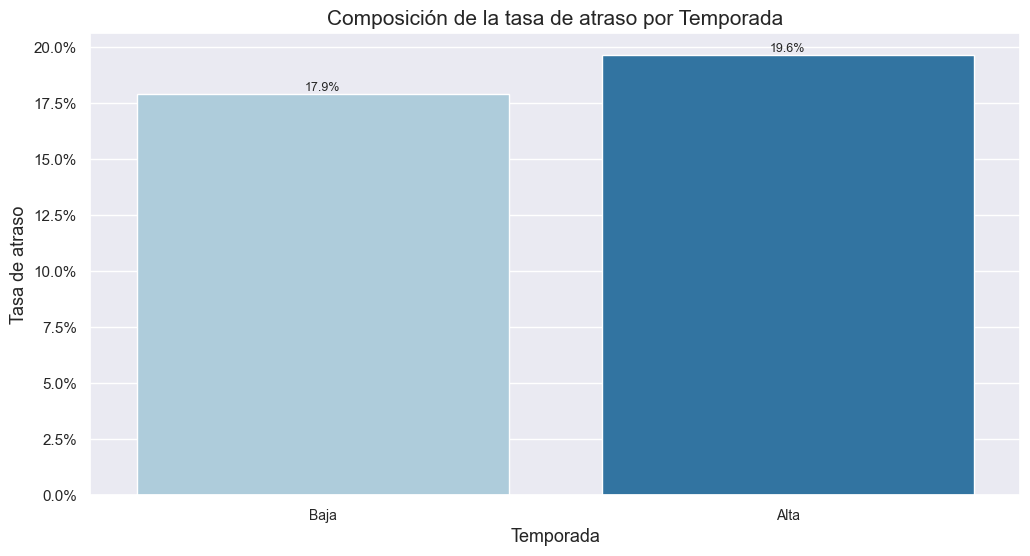

In [19]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.barplot(x=df_groupped['temporada_alta'], y=df_groupped['atraso_15'], palette='Paired')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1));
ax.set_xticklabels(labels=['Baja', 'Alta'], fontsize=10);
labels = [f'{i*100:.1f}%' for i in df_groupped['atraso_15'].values]
ax.bar_label(ax.containers[0], labels=labels, fontsize=9);
ax.set_xlabel('Temporada', fontsize=13);
ax.set_ylabel('Tasa de atraso', fontsize=13);
ax.set_title('Composición de la tasa de atraso por Temporada', fontsize=15);

#### Por Tipo de vuelo:

In [20]:
df_groupped = syntetic_df.groupby(['tipovuelo'], as_index=False)[['atraso_15']].mean().sort_values(by='atraso_15', ascending=False)
df_groupped.reset_index(drop=True, inplace=True)


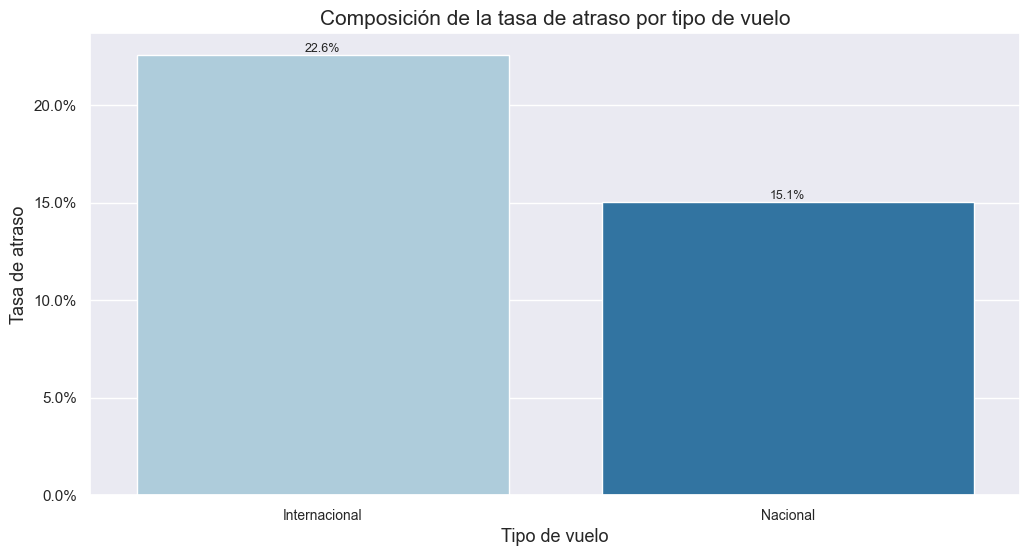

In [21]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.barplot(x=df_groupped['tipovuelo'], y=df_groupped['atraso_15'], palette='Paired')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1));
ax.set_xticklabels(labels=['Internacional', 'Nacional'], fontsize=10);
labels = [f'{i*100:.1f}%' for i in df_groupped['atraso_15'].values]
ax.bar_label(ax.containers[0], labels=labels, fontsize=9);
ax.set_xlabel('Tipo de vuelo', fontsize=13);
ax.set_ylabel('Tasa de atraso', fontsize=13);
ax.set_title('Composición de la tasa de atraso por tipo de vuelo', fontsize=15);

#### Por Periodo del día:

In [22]:
df_groupped = syntetic_df.groupby(['periodo_dia'], as_index=False)[['atraso_15']].mean().sort_values(by='atraso_15', ascending=False)
df_groupped.reset_index(drop=True, inplace=True)
df_groupped['periodo_dia'] = pd.Categorical(df_groupped['periodo_dia'], ['manana', 'tarde', 'noche'],  ordered=True)
df_groupped.sort_values(by='periodo_dia', ascending=True, inplace=True)


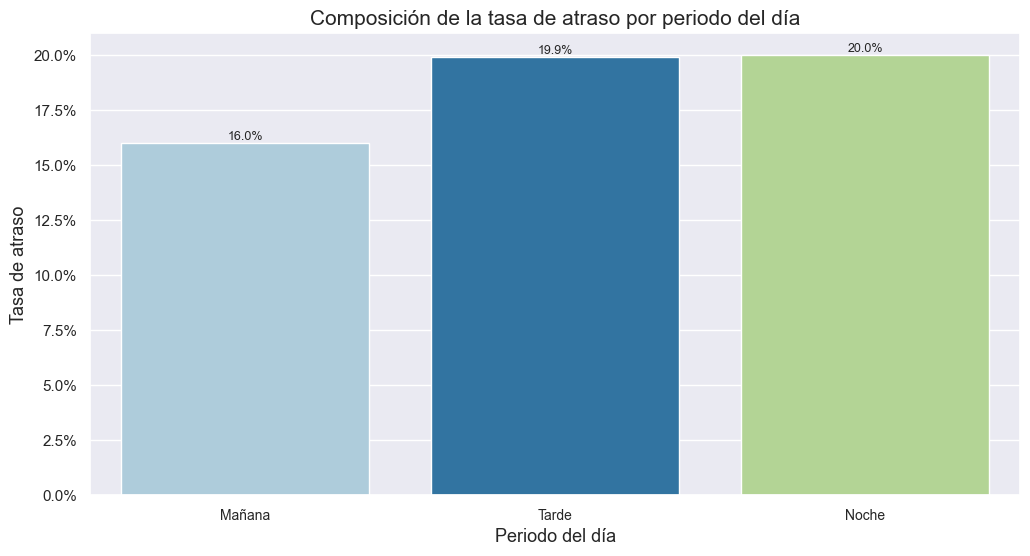

In [23]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.barplot(x=df_groupped['periodo_dia'], y=df_groupped['atraso_15'], palette='Paired', order=['manana', 'tarde', 'noche'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1));
ax.set_xticklabels(labels=['Mañana', 'Tarde', 'Noche'], fontsize=10);
labels = [f'{i*100:.1f}%' for i in df_groupped['atraso_15'].values]
ax.bar_label(ax.containers[0], labels=labels, fontsize=9);
ax.set_xlabel('Periodo del día', fontsize=13);
ax.set_ylabel('Tasa de atraso', fontsize=13);
ax.set_title('Composición de la tasa de atraso por periodo del día', fontsize=15);

Todas las variables anteriormente observadas influyen en la predicción del atraso, esto se puede observar en la medida en que las tasas de atraso son diferenciales para cada categoría de cada variable, así, por ejemplo:
- Para ``mes``, existe una tasa de atraso mayor para los meses de Julio y Diciembre, épocas asociadas a vacaciones.
- Para el caso de los días de la semana, ``diasnom``, los días viernes son los que mayor atraso tienen. Esto puede sentir sentido en la medida en que la demanda en este día es la más alta.
- En el caso de la aerolinea y el destino, existen algunas categorías con tasas muy superiores al global, por lo que estas variables serían muy importante a la hora de  construir un modelo, esto tambièn considerando la cardinalidad de dichas categorias donde se pueden observar pocos casos y quizas no valga la pena tenerlas en cuenta.
- Para la variable ``tipo_vuelo``, se observa que los vuelos internacionales tienen una tasa de atraso mayor que los nacionales, lo que era de esperarse, dado que son distancias mayores, con factores de riesgo asociados al clima de otros países.
- La variable ``periodo_dia`` muestra una diferencia de casi 4% en la tasa de atraso entre los horarios de la mañana y los de tarde/noche. 
- Finalmente, para la variable ``temporada``(Que depende del mes) como era de esperarse, se observa también mayores atrasos en las temporadas altas.

Observando los diagramas anteriores, en general todas las variables descritas parecen tener potencial de predicción, sin embargo esperaría que el tipo de vuelo sea un variable muy importante dado que la diferencia en la tasa de atraso es de más de 7%, también la aerolínea y el destino son variables importantes, que parecen discriminar la tasa de atraso de manera significativa.

Como variables externas sería interesante tener los pronosticos del clima, las estaciones, y en  general variables metereológicas que puedan ayudar a discriminar mejor la tasa de atraso. Tambìen sería interesante agregar información de los pilotos asociados a las aeronaves, en busca de asociar la expertise de los mismos(incluso en condiciones de clima desfavorables),  y así poder incluir más información al modelo.

### 4. Entrenamiento del modelo.

Una opción ideal sería poder hacer pruebas OOT(Out of time) para completar la validación del modelo sin embargo solo se tiene data del 2017 y la naturaleza del problema tiene tendencias estacionales, así que se vuelve necesario que el entrenamiento contenga datos de todo el año, por lo que definiremos una muestra _unseen_ que no este en ningun paso del entrenamiento. 

In [24]:
data = syntetic_df.sample(frac=0.90, random_state=777)
data_unseen = syntetic_df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data para modelar: ' + str(data.shape))
print('Unseen Data para predicciones ' + str(data_unseen.shape))

Data para modelar: (61385, 22)
Unseen Data para predicciones (6821, 22)


Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.
Siéntete libre de generar variables adicionales y/o complementar con variables externas.

In [25]:
data = data.drop(
    columns=['fecha_o', 'vlo_i', 'vlo_o', 'siglaori', 'ori_i', 'ori_o', 'anio'])

#### 4.0 Aditional Features

In [26]:
data['hora'] = data['fecha_i'].dt.hour # hora de la fecha programada del vuelo

In [27]:
# Verano: desde el 21 de diciembre (solsticio) al 20 de marzo (equinoccio).
# Otoño: desde el 20 de marzo (equinoccio) al 21 de junio (solsticio).
# Invierno: desde el 21 de junio (solsticio) al 21 de septiembre (equinoccio).
# Primavera: desde el 21 de septiembre (equinoccio) al 21 de diciembre (solsticio).

data['estacion'] = data['fecha_i'].apply(lambda x: ch.get_season(x)) # estacion del año(Chile) correspondiente a la fecha programada del vuelo

Las siguientes variables se construyen suponiendo que apriori se tiene la cantidad de vuelos que despegan del aeropuerto cada día/hora en el puntos de observacion, esto para poder calcular la cantidad de vuelos esperados para determinadas hora/día, suponiendo que puede afectar la tasa de atras el hecho que hayan más vuelos en una hora/día.

In [28]:
data['key'] = data['fecha_i'].dt.strftime('%Y-%m-%d %H')
temp1 = data.groupby(by=data['fecha_i'].dt.strftime('%Y-%m-%d %H'), as_index=False).size().rename(columns={'fecha_i': 'key', 
                                                                                                                         'size': 'num_vuelos_hora'})
data = data.merge(temp1, on='key', how='left')
temp2 = data.groupby(by=data['fecha_i'].dt.strftime('%Y-%m-%d'), as_index=False).size().rename(columns={'fecha_i': 'key', 
                                                                                                                      'size': 'num_vuelos_dia'})
data['key'] = data['fecha_i'].dt.strftime('%Y-%m-%d')
data = data.merge(temp2, on='key', how='left').drop(columns=['key'])
data.head(5)
del temp1, temp2

,fecha_i,des_i,emp_i,des_o,emp_o,dia,mes,dianom,tipovuelo,opera,siglades,temporada_alta,df_min,atraso_15,periodo_dia,hora,estacion,num_vuelos_hora,num_vuelos_dia
0,2017-12-02 07:34:00,SCTE,LAN,SCTE,LXP,2,12,Sabado,N,Grupo LATAM,Puerto Montt,0,7.00,0,manana,7,primavera,12,149
1,2017-08-10 20:08:00,SCAR,LAN,SCAR,LAN,10,8,Jueves,N,Grupo LATAM,Arica,0,11.00,0,noche,20,invierno,11,185
2,2017-12-17 15:07:00,SCTE,LAN,SCTE,LXP,17,12,Domingo,N,Grupo LATAM,Puerto Montt,1,3.00,0,tarde,15,primavera,13,183
3,2017-04-13 15:25:00,SCCF,SKU,SCCF,SKU,13,4,Jueves,N,Sky Airline,Calama,0,-4.00,0,tarde,15,otonio,10,176
4,2017-07-10 00:25:00,SKBO,LAN,SKBO,LAN,10,7,Lunes,I,Grupo LATAM,Bogota,0,12.00,0,noche,0,invierno,6,175


#### 4.1 Data preparation

##### 4.1.1 Check correlations

In [29]:
%%time
# Calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features using: 
# * Pearson's R for continuous-continuous cases 
# * Correlation Ratio for categorical-continuous cases 
# * Cramer's V or Theil's U for categorical-categorical cases
# Remove ['fecha_i', 'fecha_o', 'vlo_i', 'vlo_o', 'siglaori', 'ori_i', 'ori_o', 'siglaori', 'anio']
correlations = associations(data.drop(columns=['fecha_i']), compute_only =True)
correlations['corr']

CPU times: total: 1.66 s
Wall time: 1.69 s


,des_i,emp_i,des_o,emp_o,dia,mes,dianom,tipovuelo,opera,siglades,temporada_alta,df_min,atraso_15,periodo_dia,hora,estacion,num_vuelos_hora,num_vuelos_dia
des_i,1.00,0.67,1.00,0.67,0.02,0.10,0.07,1.00,0.69,1.00,0.09,0.18,0.17,0.41,0.52,0.08,0.39,0.10
emp_i,0.67,1.00,0.66,0.89,0.02,0.17,0.04,0.57,1.00,0.65,0.04,0.21,0.17,0.28,0.37,0.09,0.25,0.09
des_o,1.00,0.66,1.00,0.67,0.02,0.10,0.07,1.00,0.69,1.00,0.09,0.18,0.17,0.41,0.52,0.08,0.39,0.10
emp_o,0.67,0.89,0.67,1.00,0.02,0.17,0.04,0.73,0.98,0.66,0.05,0.21,0.18,0.31,0.40,0.10,0.27,0.09
dia,0.02,0.02,0.02,0.02,1.00,0.01,0.02,0.00,0.02,0.02,0.19,-0.01,-0.00,0.01,-0.00,0.01,0.00,-0.02
mes,0.10,0.17,0.10,0.17,0.01,1.00,0.02,0.01,0.17,0.10,-0.29,0.08,0.08,0.02,-0.01,0.84,0.08,0.29
dianom,0.07,0.04,0.07,0.04,0.02,0.02,1.00,0.06,0.04,0.07,0.03,0.05,0.06,0.02,0.05,0.02,0.13,0.58
tipovuelo,1.00,0.57,1.00,0.73,0.00,0.01,0.06,1.00,0.50,1.00,0.00,0.07,0.10,0.19,0.02,0.03,0.16,0.06
opera,0.69,1.00,0.69,0.98,0.02,0.17,0.04,0.50,1.00,0.69,0.04,0.20,0.16,0.28,0.37,0.09,0.25,0.08
siglades,1.00,0.65,1.00,0.66,0.02,0.10,0.07,1.00,0.69,1.00,0.09,0.18,0.17,0.41,0.52,0.08,0.39,0.10


Dada la matriz de correlación anterior podemos entrar a descartar variables que estan altamente correlacionadas $\approx 1$:

- ``des_i``: Alta correlación con ``des_o`` y con ``siglades``.
- ``des_o``: Alta correlación con ``des_i`` y con ``siglades``.

Por lo cual se mantiene unicamente la variable destino, ```siglades``.

- ``emp_i``: Alta correlación con ``emp_o`` y con ``opera``.
- ``emp_o``: Alta correlación con ``emp_o`` y con ``opera``.

Por lo cual se mantiene unicamente la variable de la aerolinea, ```opera``.

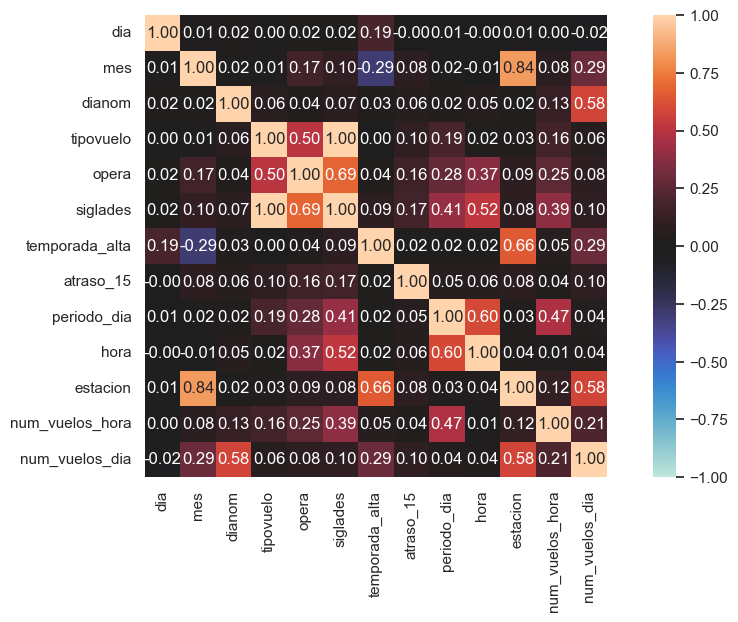

In [30]:
correlations = associations(data.drop(
    columns=['fecha_i', 'des_i', 'des_o', 'emp_i', 'emp_o', 'df_min']))

En la matriz de correlación tenemos:
- `tipo_vuelo` y `siglades` tienen correlacion = 1, lo cual era de esperarse por la misma definición de la variable.
- `tipo_vuelo` y `opera` tienen una correlacion de 0.5 lo que podría explicarse debido a que ciertas aerolineas solo tienen vuelos internacionales.
- `siglades` y `opera` tienen una correlacion de 0.69 lo que podría explicarse debido a que ciertas aerolineas solo viajan a unos destinos en particular.
- `num_vuelos_dia` y 'dianom' correlacion de 0.59, lo que indica que la cantidad de vuelos que se programan en un día depende del día de la semana.
- `num_vuelos_hora` y 'hora' correlacion de 0.75, lo que indica que la cantidad de vuelos que se programan por hora esta fuertemente sujeto a la hora del día.
Finalmente la estación con el mes y el periodo del día con la hora por ser variables derivadas .

##### 4.1.2 One hot encoding

In [31]:
data = data.drop(
    columns=['fecha_i', 'des_i', 'des_o', 'emp_i', 'emp_o', 'df_min'])

In [32]:
# data.opera.value_counts(normalize=True).to_frame()
data['opera'] = data['opera'].str.replace(' ','_').str.lower()
data[['opera']] = data[['opera']].apply(ch.condense_category, axis=0)
data.opera.value_counts().to_frame()
# data.siglades.value_counts().to_frame()

,opera
grupo_latam,36795
sky_airline,12848
other,3364
aerolineas_argentinas,1755
copa_air,1685
latin_american_wings,1496
avianca,1047
jetsmart_spa,987
gol_trans,723
american_airlines,685


In [33]:
features_to_encode = ['dianom', 'periodo_dia', 'tipovuelo', 'estacion', 'opera']
for feature in features_to_encode:
    data = ch.encode_and_bind(data, feature)

data = data.drop(columns=['tipovuelo_N']) # drop 'tipovuelo' nacional por ser de dos categorias únicamente
data

,dia,mes,siglades,temporada_alta,atraso_15,hora,num_vuelos_hora,num_vuelos_dia,dianom_Domingo,dianom_Jueves,dianom_Lunes,dianom_Martes,dianom_Miercoles,dianom_Sabado,dianom_Viernes,periodo_dia_manana,periodo_dia_noche,periodo_dia_tarde,tipovuelo_I,estacion_Verano,estacion_invierno,estacion_otonio,estacion_primavera,opera_aerolineas_argentinas,opera_american_airlines,opera_avianca,opera_copa_air,opera_gol_trans,opera_grupo_latam,opera_jetsmart_spa,opera_latin_american_wings,opera_other,opera_sky_airline
0,2,12,Puerto Montt,0,0,7,12,149,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,10,8,Arica,0,0,20,11,185,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,17,12,Puerto Montt,1,0,15,13,183,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,13,4,Calama,0,0,15,10,176,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,10,7,Bogota,0,0,0,6,175,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61380,12,12,Copiapo,0,0,7,13,189,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
61381,18,6,Nueva York,0,1,21,1,125,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
61382,28,5,Ciudad de Panama,0,0,5,6,154,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
61383,19,9,Lima,1,0,12,14,170,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


##### 4.1.3 Target Encoding

In [34]:
# data.siglades.value_counts().to_frame()
data['siglades'] = data['siglades'].str.replace(' ','_').str.lower()
data['siglades'] = ch.condense_category(data.siglades, min_count=10)
enc = TargetEncoder(cols=['siglades'])
# transform dataset
data = enc.fit_transform(data, data[['atraso_15']])
data.head(5)

c:\Users\Nia\Desktop\latam-test\venv\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\Nia\Desktop\latam-test\venv\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,dia,mes,siglades,temporada_alta,atraso_15,hora,num_vuelos_hora,num_vuelos_dia,dianom_Domingo,dianom_Jueves,dianom_Lunes,dianom_Martes,dianom_Miercoles,dianom_Sabado,dianom_Viernes,periodo_dia_manana,periodo_dia_noche,periodo_dia_tarde,tipovuelo_I,estacion_Verano,estacion_invierno,estacion_otonio,estacion_primavera,opera_aerolineas_argentinas,opera_american_airlines,opera_avianca,opera_copa_air,opera_gol_trans,opera_grupo_latam,opera_jetsmart_spa,opera_latin_american_wings,opera_other,opera_sky_airline
0,2,12,0.17,0,0,7,12,149,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,10,8,0.13,0,0,20,11,185,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,17,12,0.17,1,0,15,13,183,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,13,4,0.13,0,0,15,10,176,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,10,7,0.26,0,0,0,6,175,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


#### 4.2 Split data 

In [39]:
data.to_parquet('../../data/data_processed.parquet')

In [180]:
data=pd.read_parquet('../../data/data_processed.parquet')

In [45]:
# into train and validation sets
data_train, data_val = train_test_split(data, test_size=0.30,
                                             random_state=777,
                                             stratify=data[['atraso_15']])

x_train = data_train.drop(columns=['atraso_15']).copy()
x_val = data_val.drop(columns=['atraso_15']).copy()
y_train = data_train[['atraso_15']].copy()
y_val = data_val[['atraso_15']].copy()

eval_set = [(x_train, y_train), (x_val, y_val)]
print('Data para train: ' + str(x_train.shape))
print('Data para val: ' + str(x_val.shape))

Data para train: (42969, 32)
Data para val: (18416, 32)


#### 4.3 Instanciate model

In [54]:
# Instantiate XGBoost Classifier
xgb_clf = xgb.XGBClassifier(random_state=777,
                            objective='binary:logistic',
                            eval_metric='auc',
                            # scale_pos_weight=int(np.ceil(y_train.shape[0]/y_train.sum())), it's not necessary since there is no high class imbalance
                            use_label_encoder=False,
                            verbosity=None
                            )

##### 4.31 Random Search

In [55]:
import time
print('Search best model')
rs_param_grid = {
    'max_depth': list(range(4, 7)),  # max depth for each tree
    'learning_rate': np.round(np.linspace(0.01, 0.3, 40), 2),  # small values 
    'n_estimators': np.linspace(50, 200, 20, dtype='int'),  # --> number of trees
    # 'min_child_weight': np.linspace(1, np.ceil(y_train.shape[0]*0.10), 10, dtype='int'),  # Regularization
    # 'colsample_bytree': np.round(np.linspace(0.6, 1, 5), 2),  # subsample columns for each tree
    # 'colsample_bylevel': np.round(np.linspace(0.1, 1, 20)), # subsample columns for each lever of a tree
    # 'subsample': np.round(np.linspace(0.1, 1, 10), 2),  # subsample rows for each tree
    # 'gamma': np.round(np.linspace(0, 20, 5)),  # Regularization
}

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf,
                            param_distributions=rs_param_grid,
                            n_iter=100,
                            cv=3,
                            verbose=2,  
                            refit='roc_auc',
                            random_state=777,
                            scoring='roc_auc',
                            n_jobs=-1)
# Find best parameters
print('Execution best model')
start1 = time.time()
xgb_rs.fit(x_train, y_train)
end1 = time.time()
print('Time training random_search: ', (end1 - start1)/60, " minutes")
print("----------------------------------------------")
print("Best parameters found by RS: ", xgb_rs.best_params_)
print("Best accuracy found by RS: ", xgb_rs.best_score_)
print("Best estimator found by RS: ", xgb_rs.best_estimator_)
print("----------------------------------------------")

Search best model
Execution best model
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Nia\Desktop\latam-test\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           mo...
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.02, 0.03, 0.04, 0.05, 0.05, 0.06, 0.07, 0.08, 0.08,
       0.09, 0.1 , 0.11, 0.11, 0.12, 0.13, 0.14, 0.14, 0.15, 0.16, 0.17,
       0.17, 0.18, 0.19, 0.2 , 0.2 , 0.21, 0.22, 0.23, 0.23, 0.24, 0.25,
       0.26, 0.26, 0.27, 0.28, 0.29, 0.29, 0.3 ]),
                                        'max_depth': [4, 5, 6],
                                        'n_estimators': array([ 50,  57,  65,  73,  81,  89,  97, 105, 113, 121, 128, 136, 144,
       152, 160, 168, 176, 184, 192, 200])},
                   random_state=777, refit='roc_auc', scoring='roc_auc',
                   verbose=2)

Time training random_search:  7.396697759628296  minutes
----------------------------------------------
Best parameters found by RS:  {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.08}
Best accuracy found by RS:  0.7317961895307331
Best estimator found by RS:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.08, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=777,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
--------------------------------------

In [56]:
%%time
# Fit individual model to get some model results
print('Execution best model')
xgb_model_rs = xgb_rs.best_estimator_

# Fit model with best params
xgb_model_rs.fit(
                 x_train,
                 y_train,
                 early_stopping_rounds=50,  # Stop training if eval metric doesn´t change
                 eval_metric=['auc'],
                 eval_set=eval_set,
                 verbose=2
                 )

xgb_model_rs_features = xgb_model_rs.get_booster().feature_names
xgb_model_rs_features

Execution best model
[0]	validation_0-auc:0.68458	validation_1-auc:0.66169
[2]	validation_0-auc:0.69487	validation_1-auc:0.67058
[4]	validation_0-auc:0.70829	validation_1-auc:0.68457
[6]	validation_0-auc:0.71127	validation_1-auc:0.68802
[8]	validation_0-auc:0.71464	validation_1-auc:0.69209
[10]	validation_0-auc:0.71653	validation_1-auc:0.69210
[12]	validation_0-auc:0.72243	validation_1-auc:0.69576
[14]	validation_0-auc:0.72489	validation_1-auc:0.69775
[16]	validation_0-auc:0.72833	validation_1-auc:0.69930
[18]	validation_0-auc:0.73178	validation_1-auc:0.70191
[20]	validation_0-auc:0.73423	validation_1-auc:0.70273
[22]	validation_0-auc:0.73700	validation_1-auc:0.70442
[24]	validation_0-auc:0.73838	validation_1-auc:0.70512
[26]	validation_0-auc:0.74010	validation_1-auc:0.70568
[28]	validation_0-auc:0.74316	validation_1-auc:0.70710
[30]	validation_0-auc:0.74587	validation_1-auc:0.70849
[32]	validation_0-auc:0.74780	validation_1-auc:0.70954
[34]	validation_0-auc:0.74941	validation_1-auc:0.

['dia',
 'mes',
 'siglades',
 'temporada_alta',
 'hora',
 'num_vuelos_hora',
 'num_vuelos_dia',
 'dianom_Domingo',
 'dianom_Jueves',
 'dianom_Lunes',
 'dianom_Martes',
 'dianom_Miercoles',
 'dianom_Sabado',
 'dianom_Viernes',
 'periodo_dia_manana',
 'periodo_dia_noche',
 'periodo_dia_tarde',
 'tipovuelo_I',
 'estacion_Verano',
 'estacion_invierno',
 'estacion_otonio',
 'estacion_primavera',
 'opera_aerolineas_argentinas',
 'opera_american_airlines',
 'opera_avianca',
 'opera_copa_air',
 'opera_gol_trans',
 'opera_grupo_latam',
 'opera_jetsmart_spa',
 'opera_latin_american_wings',
 'opera_other',
 'opera_sky_airline']

In [57]:
%%time
# Get variable importance in order to filter variables with importance=0
importance = xgb_model_rs.feature_importances_
variables = x_train.columns
var_imp = pd.concat([pd.Series(variables.values), pd.Series(importance)], axis=1)
var_imp.columns = ['variable', 'importance']
var_imp.sort_values(by='importance', ascending=False, inplace=True)
var_imp = var_imp.reset_index(drop=True)
importances_xgb_model_rs = list(var_imp[var_imp['importance'] >= 0.00].variable.values)
print('[RS] Features with importance>0: ', len(importances_xgb_model_rs))

# filter importances = 0
x_train_rs = x_train[importances_xgb_model_rs]
x_val_rs = x_val[importances_xgb_model_rs]
var_imp

[RS] Features with importance>0:  32
CPU times: total: 0 ns
Wall time: 8.61 ms


,variable,importance
0,opera_gol_trans,0.07
1,opera_latin_american_wings,0.07
2,siglades,0.05
3,temporada_alta,0.04
4,mes,0.04
5,opera_sky_airline,0.04
6,opera_avianca,0.04
7,opera_other,0.04
8,hora,0.03
9,dianom_Lunes,0.03


##### 4.32 Grid Search

In [59]:
# Fit grid search with best params found by random search
xgb_clf = xgb.XGBClassifier(random_state=777,
                            objective='binary:logistic',
                            eval_metric='auc',
                            use_label_encoder=False,
                            verbosity=None,
                            # subsample=0.6,
                            # colsample_bytree=0.9,
                            )

print('Finding best parameter combination')
gs_param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.07, 0.08, 0.09],
    'n_estimators': [50, 60, 70, 80], # La disminui con respecto al random porque en la muestra de validación no parece estar mejorando significativamente
    'subsample': [0.8, 0.9, 1.0], # ayudar a mejorar el overfitting
    'colsample_bytree': [0.8, 0.9, 1.0], # ayudar a mejorar el overfitting
}


# Instantiate GridSearchCV()
xgb_gs = GridSearchCV(estimator=xgb_clf,
                      param_grid=gs_param_grid,
                      cv=3,
                      verbose=2,
                      refit='roc_auc')

# Find best parameters
print('Execution best model')
start1 = time.time()
xgb_gs.fit(x_train_rs, y_train)
end1 = time.time()
print('Time training grid_search: ', (end1 - start1)/60, " minutes")

print("----------------------------------------------")
print("Best parameters found by GS: ", xgb_gs.best_params_)
print("Best accuracy found by GS: ", xgb_gs.best_score_)
print("Best estimator found by GS: ", xgb_gs.best_estimator_)
print("----------------------------------------------")

Finding best parameter combination
Execution best model
Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END colsample_bytree=0.8, learning_rate=0.07, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.07, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.07, max_depth=4, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.07, max_depth=4, n_estimators=50, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.07, max_depth=4, n_estimators=50, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.07, max_depth=4, n_estimators=50, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.07, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.07, max_depth=4, n_estimators

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=777, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.07, 0.08, 0.09],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [50, 60, 70, 80],
                         'subsample': [0.8, 0.9, 1.0]},
             refit='roc_auc', verbose=2)

Time training grid_search:  22.514740788936614  minutes
----------------------------------------------
Best parameters found by GS:  {'colsample_bytree': 1.0, 'learning_rate': 0.09, 'max_depth': 6, 'n_estimators': 80, 'subsample': 0.9}
Best accuracy found by GS:  0.8220810351648863
Best estimator found by GS:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=777, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=

In [68]:
# Fit gs model to get model results
xgb_model_gs = xgb_gs.best_estimator_

eval_set = [(x_train_rs, y_train), (x_val_rs, y_val)]
# Fit model with best params
xgb_model_gs.fit(
                 x_train_rs,
                 y_train,
                 early_stopping_rounds=50,  # Stop training if eval metric doesn´t change
                 eval_metric=['auc'],
                 eval_set=eval_set,
                 verbose=2
                 )

# del x_train_rs, x_val_rs

[0]	validation_0-auc:0.68418	validation_1-auc:0.66742
[2]	validation_0-auc:0.70020	validation_1-auc:0.67807
[4]	validation_0-auc:0.70945	validation_1-auc:0.68737
[6]	validation_0-auc:0.71331	validation_1-auc:0.69041
[8]	validation_0-auc:0.71725	validation_1-auc:0.69361
[10]	validation_0-auc:0.72159	validation_1-auc:0.69691
[12]	validation_0-auc:0.72484	validation_1-auc:0.69915
[14]	validation_0-auc:0.72817	validation_1-auc:0.70154
[16]	validation_0-auc:0.72974	validation_1-auc:0.70161
[18]	validation_0-auc:0.73325	validation_1-auc:0.70443
[20]	validation_0-auc:0.73564	validation_1-auc:0.70613
[22]	validation_0-auc:0.73827	validation_1-auc:0.70737
[24]	validation_0-auc:0.73991	validation_1-auc:0.70742
[26]	validation_0-auc:0.74166	validation_1-auc:0.70898
[28]	validation_0-auc:0.74421	validation_1-auc:0.70993
[30]	validation_0-auc:0.74648	validation_1-auc:0.71055
[32]	validation_0-auc:0.74817	validation_1-auc:0.71149
[34]	validation_0-auc:0.75215	validation_1-auc:0.71410
[36]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=777, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [69]:
# filter importances = 0
# Get variable importance in order to filter variables with importance=0
importance = xgb_model_gs.feature_importances_
variables = x_train_rs.columns
var_imp = pd.concat([pd.Series(variables.values), pd.Series(importance)], axis=1)
var_imp.columns = ['variable', 'importance']
var_imp.sort_values(by='importance', ascending=False, inplace=True)
var_imp = var_imp.reset_index(drop=True)
importances_xgb_model_gs = list(var_imp[var_imp['importance'] > 0.00].variable.values)
print('[GS] Features with importance>0: ', len(importances_xgb_model_gs))
x_train_gs = x_train[importances_xgb_model_gs]
x_val_gs = x_val[importances_xgb_model_gs]

eval_set = [(x_train_gs, y_train), (x_val_gs, y_val)]

# Fit model with new filtered X by GS
xgb_model_gs.fit(x_train_gs,
                 y_train,
                 early_stopping_rounds=30,
                 eval_metric=['auc'],
                 eval_set=eval_set,
                 verbose=True)

[GS] Features with importance>0:  31
[0]	validation_0-auc:0.68418	validation_1-auc:0.66742
[1]	validation_0-auc:0.69419	validation_1-auc:0.67422
[2]	validation_0-auc:0.70020	validation_1-auc:0.67807
[3]	validation_0-auc:0.70679	validation_1-auc:0.68467
[4]	validation_0-auc:0.70945	validation_1-auc:0.68737
[5]	validation_0-auc:0.71143	validation_1-auc:0.68972
[6]	validation_0-auc:0.71331	validation_1-auc:0.69041
[7]	validation_0-auc:0.71511	validation_1-auc:0.69232
[8]	validation_0-auc:0.71725	validation_1-auc:0.69361
[9]	validation_0-auc:0.71879	validation_1-auc:0.69439
[10]	validation_0-auc:0.72159	validation_1-auc:0.69691
[11]	validation_0-auc:0.72286	validation_1-auc:0.69732
[12]	validation_0-auc:0.72484	validation_1-auc:0.69915
[13]	validation_0-auc:0.72633	validation_1-auc:0.70061
[14]	validation_0-auc:0.72817	validation_1-auc:0.70154
[15]	validation_0-auc:0.72916	validation_1-auc:0.70152
[16]	validation_0-auc:0.72974	validation_1-auc:0.70161
[17]	validation_0-auc:0.73153	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=777, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### 4.4 Final Model

In [97]:
# try more combinations based on initial estimation by GS and RS
xgb_model = xgb.XGBClassifier(
                              base_score=0.5,
                              booster='gbtree',
                              eval_metric=['auc'],
                              learning_rate=0.09,
                              max_depth=5,
                              n_estimators=90,
                              random_state=777,
                              subsample=0.8,
                              gamma=4,
                            #   min_child_weight=50,
                            #   scale_pos_weight=1,
                              importance_type='gain',
                              verbosity=None,
                              use_label_encoder=False)

eval_set = [(x_train_gs, y_train), (x_val_gs, y_val)]
xgb_model.fit(x_train_gs, y_train,
              early_stopping_rounds=50,
              eval_metric=['auc'],
              eval_set=eval_set,
              verbose=True)

[0]	validation_0-auc:0.66338	validation_1-auc:0.64810
[1]	validation_0-auc:0.67490	validation_1-auc:0.65869
[2]	validation_0-auc:0.68433	validation_1-auc:0.66887
[3]	validation_0-auc:0.69061	validation_1-auc:0.67381
[4]	validation_0-auc:0.69256	validation_1-auc:0.67570
[5]	validation_0-auc:0.69411	validation_1-auc:0.67632
[6]	validation_0-auc:0.69503	validation_1-auc:0.67752
[7]	validation_0-auc:0.69589	validation_1-auc:0.67826
[8]	validation_0-auc:0.69767	validation_1-auc:0.67941
[9]	validation_0-auc:0.69951	validation_1-auc:0.68174
[10]	validation_0-auc:0.70267	validation_1-auc:0.68469
[11]	validation_0-auc:0.70393	validation_1-auc:0.68522
[12]	validation_0-auc:0.70476	validation_1-auc:0.68630
[13]	validation_0-auc:0.70567	validation_1-auc:0.68734
[14]	validation_0-auc:0.70755	validation_1-auc:0.68923
[15]	validation_0-auc:0.70974	validation_1-auc:0.69160
[16]	validation_0-auc:0.71022	validation_1-auc:0.69166
[17]	validation_0-auc:0.71161	validation_1-auc:0.69245
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric=['auc'], gamma=4, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=90, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=777,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [111]:
vars = [
  'opera_gol_trans', 'siglades', 
  'opera_latin_american_wings', 
  'mes', 'hora', 'opera_avianca', 
  'opera_sky_airline', 'opera_american_airlines', 
  'num_vuelos_dia', 'opera_aerolineas_argentinas', 
  'opera_other', 'tipovuelo_I', 'dianom_Lunes', 
  'temporada_alta', 'opera_grupo_latam', 'dianom_Martes', 
  'estacion_invierno', 'dianom_Sabado', 
  'estacion_otonio', 'dia', 'dianom_Domingo', 
  'periodo_dia_manana', 'estacion_Verano', 
  'periodo_dia_noche', 'dianom_Viernes', 
  'periodo_dia_tarde', 'num_vuelos_hora', 
  'estacion_primavera', 'opera_jetsmart_spa', 
  'dianom_Jueves', 'dianom_Miercoles',
  'atraso_15',
      ]

datan = data[vars].copy()
data_train, data_test = train_test_split(datan,
                                             test_size=0.30,
                                             random_state=777,
                                             stratify=datan[['atraso_15']])

x_train = data_train.drop(columns=['atraso_15'], axis=1).copy()
x_val = data_test.drop(columns=['atraso_15'], axis=1).copy()
y_train = y_train[['atraso_15']].copy()
y_val = y_val[['atraso_15']].copy()

eval_set = [(x_train, y_train), (x_val, y_val)]

# Final Model
xgb_model = xgb.XGBClassifier(
                              base_score=0.5,
                              booster='gbtree',
                              eval_metric=['auc'],
                              learning_rate=0.09,
                              max_depth=5,
                              n_estimators=90,
                              random_state=777,
                              subsample=0.8,
                              gamma=4,
                              importance_type='gain',
                              verbosity=None,
                              use_label_encoder=False
                            )
xgb_model.fit(x_train, y_train,
              early_stopping_rounds=50,
              eval_metric=['auc'],
              eval_set=eval_set,
              verbose=True)

[0]	validation_0-auc:0.66338	validation_1-auc:0.64810
[1]	validation_0-auc:0.67490	validation_1-auc:0.65869
[2]	validation_0-auc:0.68433	validation_1-auc:0.66887
[3]	validation_0-auc:0.69061	validation_1-auc:0.67381
[4]	validation_0-auc:0.69256	validation_1-auc:0.67570
[5]	validation_0-auc:0.69411	validation_1-auc:0.67632
[6]	validation_0-auc:0.69503	validation_1-auc:0.67752
[7]	validation_0-auc:0.69589	validation_1-auc:0.67826
[8]	validation_0-auc:0.69767	validation_1-auc:0.67941
[9]	validation_0-auc:0.69951	validation_1-auc:0.68174
[10]	validation_0-auc:0.70267	validation_1-auc:0.68469
[11]	validation_0-auc:0.70393	validation_1-auc:0.68522
[12]	validation_0-auc:0.70476	validation_1-auc:0.68630
[13]	validation_0-auc:0.70567	validation_1-auc:0.68734
[14]	validation_0-auc:0.70755	validation_1-auc:0.68923
[15]	validation_0-auc:0.70974	validation_1-auc:0.69160
[16]	validation_0-auc:0.71022	validation_1-auc:0.69166
[17]	validation_0-auc:0.71161	validation_1-auc:0.69245
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric=['auc'], gamma=4, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=90, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=777,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

##### 4.4.1 Features importances

In [112]:
importance = xgb_model.feature_importances_
variables = x_train.columns
var_imp = pd.concat([pd.Series(variables.values), pd.Series(importance)], axis=1)
var_imp.columns = ['variable', 'importance']
var_imp.sort_values(by='importance', ascending=False, inplace=True)
var_imp = var_imp.reset_index(drop=True)
importances_xgb_model = list(var_imp[var_imp['importance'] > 0].variable.values)
print('Number of Features in final model: ', len(importances_xgb_model))
var_imp

Number of Features in final model:  31


,variable,importance
0,siglades,0.08
1,opera_gol_trans,0.06
2,opera_latin_american_wings,0.05
3,mes,0.04
4,num_vuelos_dia,0.04
5,opera_avianca,0.04
6,tipovuelo_I,0.04
7,hora,0.04
8,dianom_Lunes,0.04
9,estacion_invierno,0.04


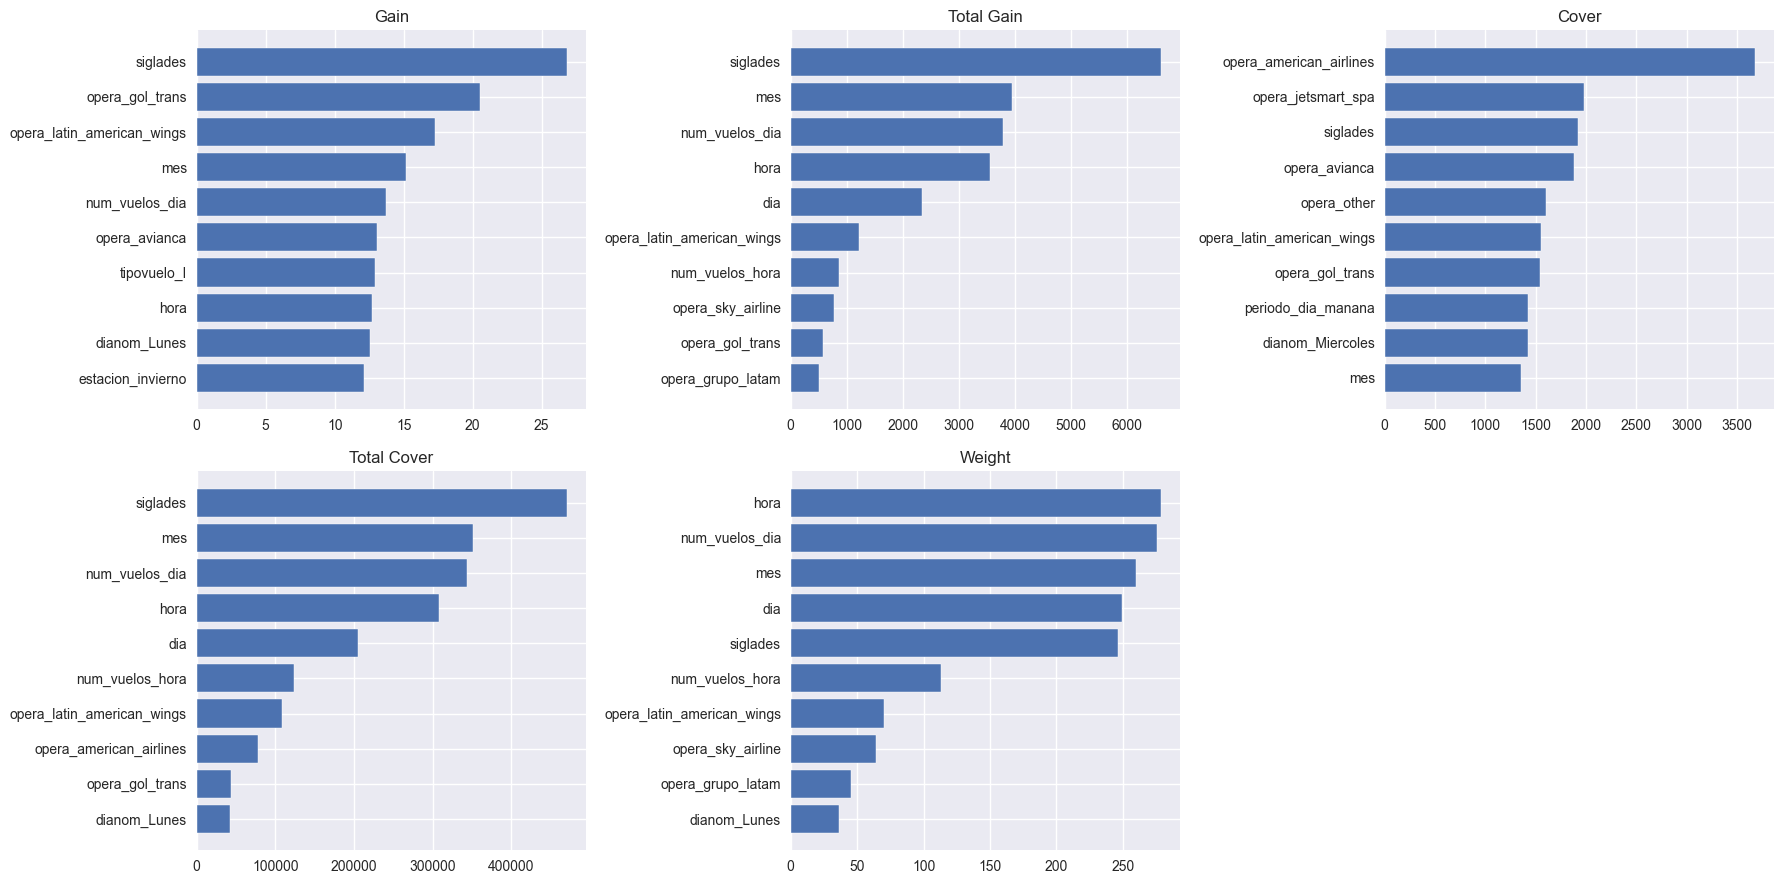

,Gain,Total_gain,Cover,Total_cover,Weight
estacion_primavera,4.68,51.47,89.42,983.66,11.00
dianom_Miercoles,4.87,58.39,"1,419.83","17,037.98",12.00
opera_jetsmart_spa,5.18,36.26,"1,982.73","13,879.13",7.00
periodo_dia_manana,5.58,39.08,"1,428.20","9,997.42",7.00
dianom_Jueves,6.62,138.93,463.10,"9,725.00",21.00
dianom_Viernes,7.04,190.09,657.67,"17,756.98",27.00
periodo_dia_tarde,7.09,70.92,983.08,"9,830.84",10.00
num_vuelos_hora,7.54,852.38,"1,098.36","124,114.49",113.00
dianom_Domingo,7.80,202.70,"1,121.65","29,162.99",26.00
opera_aerolineas_argentinas,8.52,136.37,897.83,"14,365.34",16.00


In [188]:
ch.plot_importances(model=xgb_model, show=True)

##### 4.4.2 Save Model and Results

In [115]:
# ======================================================================================================================
# Save model pkl and inputs (X, Y)
# ======================================================================================================================
# files use to train
path_model_inputs = '../../data/'
file_x = 'x_train.parquet'
x_train.reset_index(inplace=True, drop=True)
x_train.to_parquet(path_model_inputs+file_x)
file_y = 'y_train.parquet'
y_train.to_parquet(path_model_inputs+file_y)

# files use to test
file_xt = 'x_test.parquet'
x_val.reset_index(inplace=True, drop=True)
x_val.to_parquet(path_model_inputs+file_xt)
file_yt = 'y_test.parquet'
y_val.to_parquet(path_model_inputs+file_yt)

In [116]:
path_model_pkl =  '../../models/'
file_model = 'xgb_model.pkl'
pickle.dump(xgb_model, open(path_model_pkl+file_model, 'wb'))

### 5. Evaluación del modelo.
Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?

#### 5.0 Load Model

In [118]:
# load trained model
path_model_pkl =  '../../models/'
file_model = 'xgb_model.pkl'
xgb_model = pickle.load(open(path_model_pkl+file_model, 'rb'))

#### 5.1 Tabla de validación del modelo en train 

In [119]:
# Y_train and estimated probabilities for val table
y_predict_train = xgb_model.predict_proba(x_train)
y_predict_train = pd.concat([y_train.reset_index(drop=True), pd.Series(y_predict_train[:, 1])], axis=1)
y_predict_train.columns = ['atraso_15', 'probability']

# Y_test and estimated probabilities for val table
y_predict_val = xgb_model.predict_proba(x_val).copy()
y_predict_val = pd.concat([y_val.reset_index(drop=True), pd.Series(y_predict_val[:, 1])], axis=1)
y_predict_val.columns = ['atraso_15', 'probability']

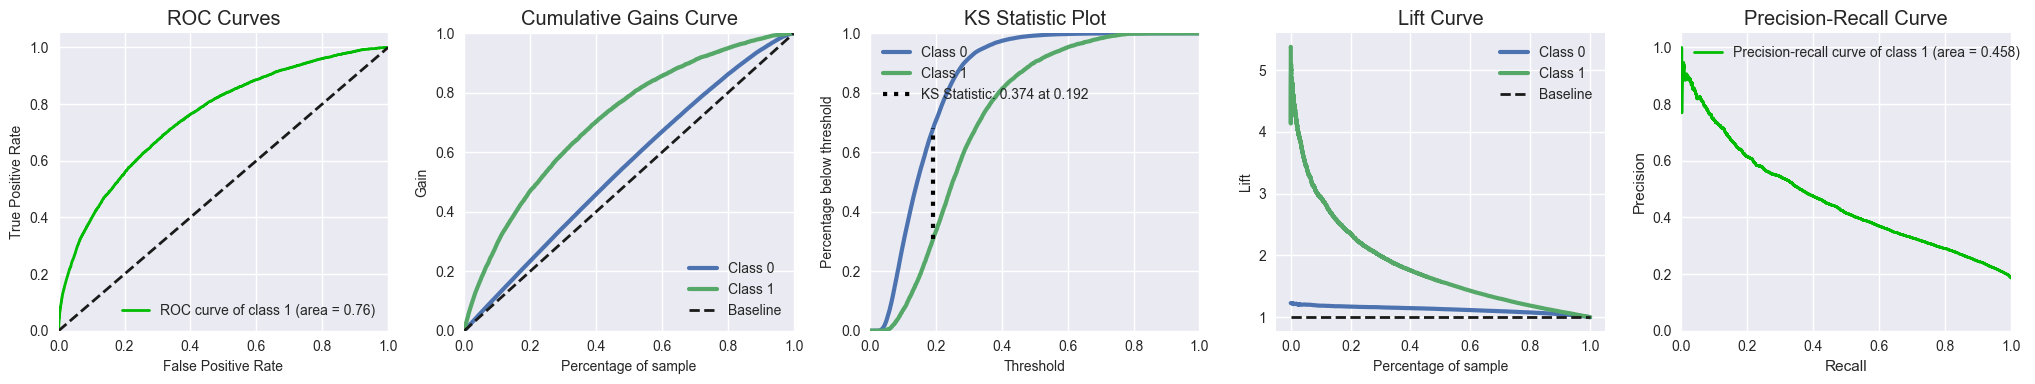

,Population,Events,Event_Rate,KS,AUC,AR,Gini,Odds_sup,Odds_inf,Breaks
0,"42,969","7,993",18.60%,37.3,75.6,51.3,41.7,28.6,0.8,0.0


,Min_prob,Max_prob,Total,Event,NoEvent,Event_Rate,NoEvent_Rate,RateAcum_EventUP,RateAcum_EventDOWN,KS,RateUP,RateDOWN,Odds,Odds_Acum,Lift
Decil,,,,,,,,,,,,,,,
1,0.02,0.07,"4,297",145,"4,152",3.37%,96.63%,1.81%,100.00%,10.06,3.37%,18.60%,28.6,28.6,0.15
2,0.07,0.09,"4,297",256,"4,041",5.96%,94.04%,5.02%,98.19%,18.41,4.67%,20.29%,15.8,20.4,0.26
3,0.09,0.11,"4,297",324,"3,973",7.54%,92.46%,9.07%,94.98%,25.71,5.62%,22.09%,12.3,16.8,0.33
4,0.11,0.13,"4,297",423,"3,874",9.84%,90.16%,14.36%,90.93%,31.50,6.68%,24.16%,9.2,14.0,0.43
5,0.13,0.16,"4,297",533,"3,764",12.40%,87.60%,21.03%,85.64%,35.59,7.82%,26.55%,7.1,11.8,0.54
6,0.16,0.19,"4,296",691,"3,605",16.08%,83.92%,29.68%,78.97%,37.25,9.20%,29.38%,5.2,9.9,0.70
7,0.19,0.22,"4,297",844,"3,453",19.64%,80.36%,40.24%,70.32%,36.57,10.69%,32.70%,4.1,8.4,0.86
8,0.22,0.26,"4,297","1,015","3,282",23.62%,76.38%,52.93%,59.76%,33.25,12.31%,37.06%,3.2,7.1,1.03
9,0.26,0.33,"4,297","1,412","2,885",32.86%,67.14%,70.60%,47.07%,23.83,14.59%,43.77%,2.0,5.9,1.44


In [120]:
train = ch.validation_table(df=y_predict_train,
                            target='atraso_15',
                            prob='probability',
                            bins=10,
                            type_output='console')
train['resume_sc']
train['score_card']

#### 5.2 Tabla de validación del modelo en Val 

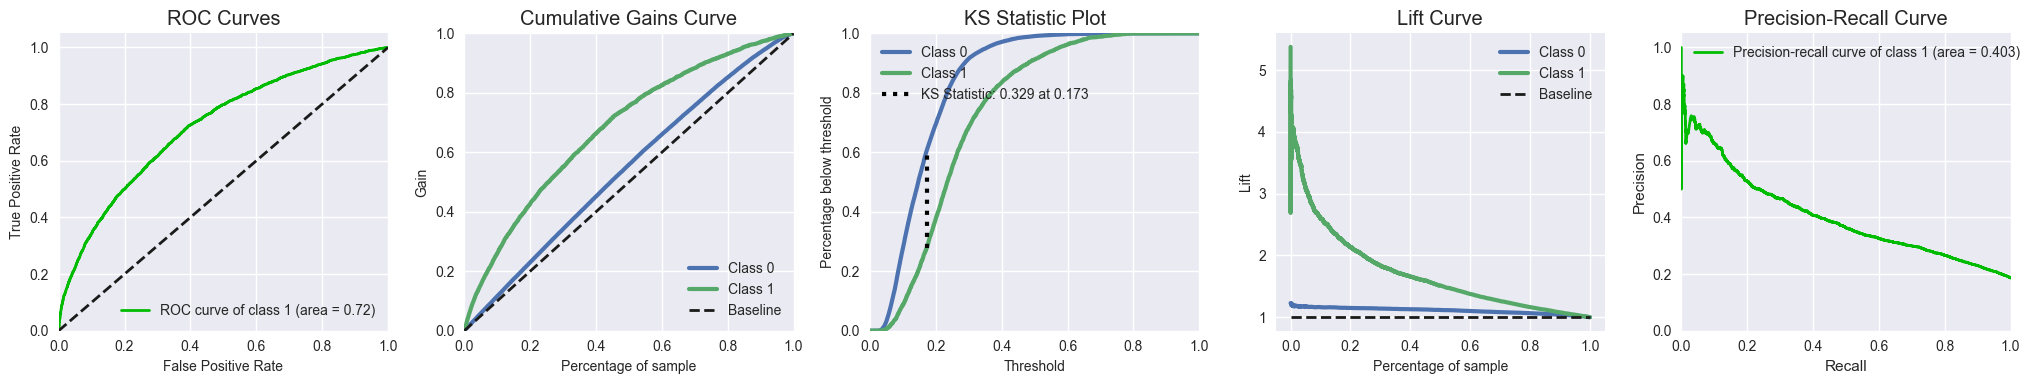

,Population,Events,Event_Rate,KS,AUC,AR,Gini,Odds_sup,Odds_inf,Breaks
0,"18,416","3,426",18.60%,32.3,72.2,44.4,36.1,17.2,1.1,0.0


,Min_prob,Max_prob,Total,Event,NoEvent,Event_Rate,NoEvent_Rate,RateAcum_EventUP,RateAcum_EventDOWN,KS,RateUP,RateDOWN,Odds,Odds_Acum,Lift
Decil,,,,,,,,,,,,,,,
1,0.02,0.07,"1,842",101,"1,741",5.48%,94.52%,2.95%,100.00%,8.67,5.48%,18.60%,17.2,17.2,0.24
2,0.07,0.09,"1,842",135,"1,707",7.33%,92.67%,6.89%,97.05%,16.11,6.41%,20.06%,12.6,14.6,0.32
3,0.09,0.11,"1,841",164,"1,677",8.91%,91.09%,11.68%,93.11%,22.51,7.24%,21.65%,10.2,12.8,0.39
4,0.11,0.14,"1,842",197,"1,645",10.69%,89.31%,17.43%,88.32%,27.74,8.10%,23.47%,8.4,11.3,0.47
5,0.14,0.16,"1,841",239,"1,602",12.98%,87.02%,24.40%,82.57%,31.45,9.08%,25.60%,6.7,10.0,0.57
6,0.16,0.19,"1,842",318,"1,524",17.26%,82.74%,33.68%,75.60%,32.33,10.44%,28.13%,4.8,8.6,0.76
7,0.19,0.22,"1,841",384,"1,457",20.86%,79.14%,44.89%,66.32%,30.85,11.93%,30.84%,3.8,7.4,0.91
8,0.22,0.26,"1,842",426,"1,416",23.13%,76.87%,57.33%,55.11%,27.86,13.33%,34.17%,3.3,6.5,1.01
9,0.26,0.33,"1,841",570,"1,271",30.96%,69.04%,73.96%,42.67%,19.70,15.29%,39.70%,2.2,5.5,1.35


In [121]:
test = ch.validation_table(df=y_predict_val,
                           target='atraso_15',
                           prob='probability',
                           bins=10,
                           type_output='console')
test['resume_sc']
test['score_card']

#### 5.3 Exportar resultados html report

In [132]:
# Export final results
ch.validation_table(df=y_predict_train,
                target='atraso_15',
                prob='probability',
                bins=10,
                type_output="html",
                path_output='../../docs/validation_table_train',
                plots=False)
ch.validation_table(df=y_predict_val,
                target='atraso_15',
                prob='probability',
                bins=10,
                type_output="html",
                path_output='../../docs/validation_table_val',
                plots=False)

#### 5.4 Resultados unseen data

In [184]:
# transform data
data_unseen
data_unseen = data_unseen.drop(
    columns=['fecha_o', 'vlo_i', 'vlo_o', 'siglaori', 'ori_i', 'ori_o', 'anio'])
data_unseen['hora'] = data_unseen['fecha_i'].dt.hour # hora de la fecha programada del vuelo
data_unseen['estacion'] = data_unseen['fecha_i'].apply(lambda x: ch.get_season(x)) # estacion del año(Chile) correspondiente a la fecha programada del vuelo

data_unseen['key'] = data_unseen['fecha_i'].dt.strftime('%Y-%m-%d %H')
temp1 = data_unseen.groupby(by=data_unseen['fecha_i'].dt.strftime('%Y-%m-%d %H'), as_index=False).size().rename(columns={'fecha_i': 'key', 
                                                                                                                         'size': 'num_vuelos_hora'})
data_unseen = data_unseen.merge(temp1, on='key', how='left')
temp2 = data_unseen.groupby(by=data_unseen['fecha_i'].dt.strftime('%Y-%m-%d'), as_index=False).size().rename(columns={'fecha_i': 'key', 
                                                                                                                      'size': 'num_vuelos_dia'})
data_unseen['key'] = data_unseen['fecha_i'].dt.strftime('%Y-%m-%d')
data_unseen = data_unseen.merge(temp2, on='key', how='left').drop(columns=['key'])
data_unseen.head(5)
del temp1, temp2

data_unseen = data_unseen.drop(
    columns=['fecha_i', 'des_i', 'des_o', 'emp_i', 'emp_o', 'df_min'])

data_unseen['opera'] = data_unseen['opera'].str.replace(' ','_').str.lower()
data_unseen[['opera']] = data_unseen[['opera']].apply(ch.condense_category, axis=0)


features_to_encode = ['dianom', 'periodo_dia', 'tipovuelo', 'estacion', 'opera']
for feature in features_to_encode:
    data_unseen = ch.encode_and_bind(data_unseen, feature)

data_unseen = data_unseen.drop(columns=['tipovuelo_N']) 
data_unseen = enc.transform(data_unseen)
data_unseen = data_unseen[data.columns]

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,anio,dianom,tipovuelo,opera,siglaori,siglades,temporada_alta,df_min,atraso_15,periodo_dia
0,2017-01-14 23:30:00,226,SCEL,KMIA,AAL,2017-01-14 23:21:00,226,SCEL,KMIA,AAL,14,1,2017,Sabado,I,American Airlines,Santiago,Miami,1,-9.00,0,noche
1,2017-01-07 22:00:00,912,SCEL,KMIA,AAL,2017-01-07 21:55:00,912,SCEL,KMIA,AAL,7,1,2017,Sabado,I,American Airlines,Santiago,Miami,1,-5.00,0,noche
2,2017-01-21 22:00:00,912,SCEL,KMIA,AAL,2017-01-21 22:03:00,912,SCEL,KMIA,AAL,21,1,2017,Sabado,I,American Airlines,Santiago,Miami,1,3.00,0,noche
3,2017-01-22 22:00:00,912,SCEL,KMIA,AAL,2017-01-22 21:58:00,912,SCEL,KMIA,AAL,22,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,-2.00,0,noche
4,2017-01-30 22:00:00,912,SCEL,KMIA,AAL,2017-01-30 22:00:00,912,SCEL,KMIA,AAL,30,1,2017,Lunes,I,American Airlines,Santiago,Miami,1,0.00,0,noche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6816,2017-12-21 18:26:00,255,SCEL,SCTE,JAT,2017-12-21 18:32:00,255.0,SCEL,SCTE,JAT,21,12,2017,Jueves,N,JetSmart SPA,Santiago,Puerto Montt,1,6.00,0,tarde
6817,2017-12-20 11:57:00,281,SCEL,SCQP,JAT,2017-12-20 12:02:00,281.0,SCEL,SCQP,JAT,20,12,2017,Miercoles,N,JetSmart SPA,Santiago,Temuco,1,5.00,0,manana
6818,2017-12-27 11:57:00,281,SCEL,SCQP,JAT,2017-12-27 11:58:00,281.0,SCEL,SCQP,JAT,27,12,2017,Miercoles,N,JetSmart SPA,Santiago,Temuco,1,1.00,0,manana
6819,2017-12-29 04:05:00,301,SCEL,SCCI,JAT,2017-12-29 04:00:00,301.0,SCEL,SCCI,JAT,29,12,2017,Viernes,N,JetSmart SPA,Santiago,Punta Arenas,1,-5.00,0,noche


,fecha_i,des_i,emp_i,des_o,emp_o,dia,mes,dianom,tipovuelo,opera,siglades,temporada_alta,df_min,atraso_15,periodo_dia,hora,estacion,num_vuelos_hora,num_vuelos_dia
0,2017-01-14 23:30:00,KMIA,AAL,KMIA,AAL,14,1,Sabado,I,American Airlines,Miami,1,-9.00,0,noche,23,Verano,1,16
1,2017-01-07 22:00:00,KMIA,AAL,KMIA,AAL,7,1,Sabado,I,American Airlines,Miami,1,-5.00,0,noche,22,Verano,1,20
2,2017-01-21 22:00:00,KMIA,AAL,KMIA,AAL,21,1,Sabado,I,American Airlines,Miami,1,3.00,0,noche,22,Verano,1,16
3,2017-01-22 22:00:00,KMIA,AAL,KMIA,AAL,22,1,Domingo,I,American Airlines,Miami,1,-2.00,0,noche,22,Verano,3,26
4,2017-01-30 22:00:00,KMIA,AAL,KMIA,AAL,30,1,Lunes,I,American Airlines,Miami,1,0.00,0,noche,22,Verano,3,30


In [185]:
# Y_test and estimated probabilities for test table
x_test = data_unseen[x_train.columns]
y_test = data_unseen[['atraso_15']].copy()
y_predict_test = xgb_model.predict_proba(x_test)
y_predict_test = pd.concat([y_test.reset_index(drop=True), pd.Series(y_predict_test[:, 1])], axis=1)
y_predict_test.columns = ['atraso_15', 'probability']

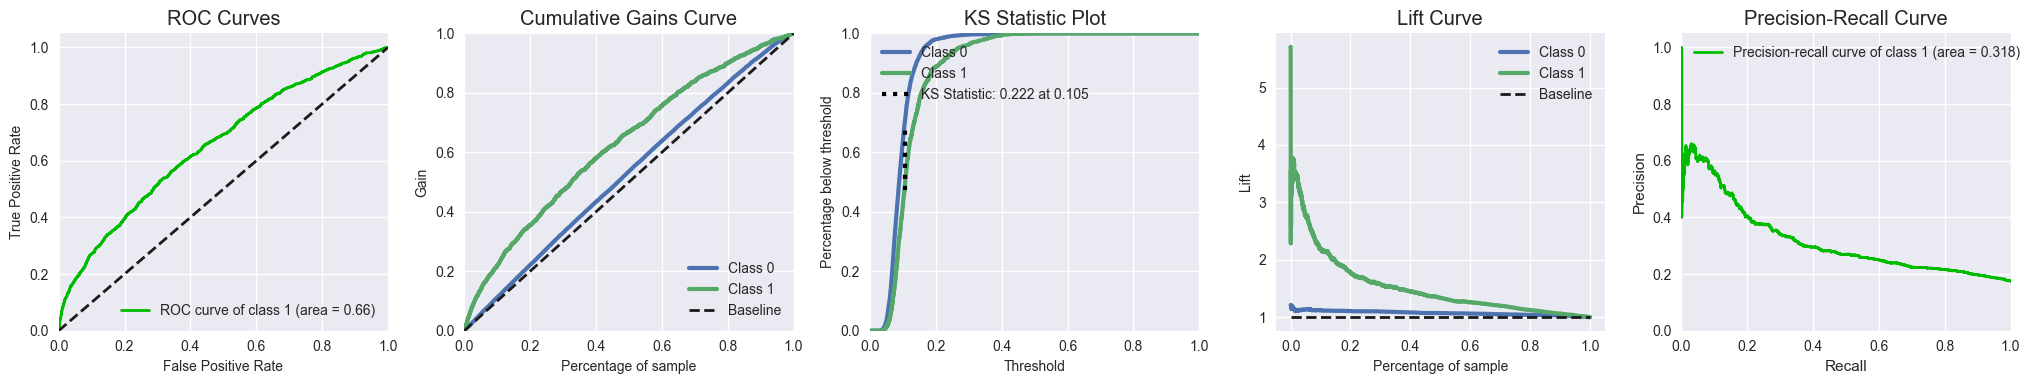

,Population,Events,Event_Rate,KS,AUC,AR,Gini,Odds_sup,Odds_inf,Breaks
0,"6,821","1,195",17.52%,21.8,65.5,31.0,25.6,11.9,1.6,0.0


,Min_prob,Max_prob,Total,Event,NoEvent,Event_Rate,NoEvent_Rate,RateAcum_EventUP,RateAcum_EventDOWN,KS,RateUP,RateDOWN,Odds,Odds_Acum,Lift
Decil,,,,,,,,,,,,,,,
1,0.03,0.06,683,53,630,7.76%,92.24%,4.44%,100.00%,6.76,7.76%,17.52%,11.9,11.9,0.37
2,0.06,0.07,682,67,615,9.82%,90.18%,10.04%,95.56%,12.09,8.79%,18.61%,9.2,10.4,0.46
3,0.07,0.08,682,74,608,10.85%,89.15%,16.23%,89.96%,16.70,9.48%,19.70%,8.2,9.6,0.51
4,0.08,0.08,682,98,584,14.37%,85.63%,24.44%,83.77%,18.88,10.70%,20.97%,6.0,8.3,0.68
5,0.08,0.09,682,103,579,15.10%,84.90%,33.05%,75.56%,20.55,11.58%,22.07%,5.6,7.6,0.71
6,0.09,0.10,682,107,575,15.69%,84.31%,42.01%,66.95%,21.82,12.26%,23.46%,5.4,7.2,0.74
7,0.10,0.11,682,128,554,18.77%,81.23%,52.72%,57.99%,20.96,13.19%,25.40%,4.3,6.6,0.88
8,0.11,0.12,682,140,542,20.53%,79.47%,64.44%,47.28%,18.87,14.11%,27.61%,3.9,6.1,0.97
9,0.12,0.15,682,163,519,23.90%,76.10%,78.08%,35.56%,14.46,15.20%,31.16%,3.2,5.6,1.13


In [186]:
test = ch.validation_table(df=y_predict_test,
                           target='atraso_15',
                           prob='probability',
                           bins=10,
                           type_output='console')
test['resume_sc']
test['score_card']

En términos generales el modelo presentó en Training un $AUC\approx 0,76$, versus en validación un $AUC\approx 0,73$ lo que para un modelo de clasificación es aceptable. Sin embargo al evaluar en el conjunto _unseen data_ el modelo presenta un $AUC\approx 0,66$ lo que podría ser una señal de sobreajuste. Se podrían probar metodos diferentes para codear la variable ``siglades``, ya que es la más importante en el modelo y quizas es la que esta causando la diferencia, sin embargo la mejor elección en este caso es siempre hacer pruebas out of time para chequear como se comporta el modelo en otros periodos por lo que la variable respuesta tiene un caracter estacional.

La metrica de uso depende mucho del contexto del caso de uso, si el objetivo del modelo es predecir el restraso o no(1 o 0) estrictamente, entonces es muy util revisar la matriz de confusión o el accuracy global, y mover el thershold que determina el 1 o el 0 en función de los requerimientos del negocio(PE. ¿Que es más importante, pronosticar correcatmente el atraso o ?). Ahora bien si el problema es más de caracter probabilístico, como parece es este caso, funciona mucho mejor una metrica como el AUC (o AUC-PR para problemas altamente imbalanceados) o el KS que discriminan el poder de separación de un modelo a traves de toda el score y no sobre un unico punto de corte.

Escogí XGBoost porque es uno de los algoritmos más usados en la indsutria académica y laboral. Este tipo de algoritmo presenta performance superiores en modelos con datos tabulares y con variable respuesta de caracter binario,  además de sus ventajas competitivas en terminos de accuracy, también presenta ventajas como velocidad, manejo de NAs y outliers.

Se podría mejorar con información asociada al clima que es lo que más genera restrasos en los vuelos, también como se mencionaba anteriormente variables asociadas a las aeronaves, mantenimientos, rendimiendo etc, así como información relevante del piloto.



